<a href="https://colab.research.google.com/github/BYU-Hydroinformatics/baseflow-notebooks/blob/main/baseflow_single_station.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install baseflow package from github

In [46]:
!pip install git+https://github.com/BYU-Hydroinformatics/baseflow.git

  Cloning https://github.com/BYU-Hydroinformatics/baseflow.git to /tmp/pip-req-build-jqe1dw0r
  Running command git clone --filter=blob:none --quiet https://github.com/BYU-Hydroinformatics/baseflow.git /tmp/pip-req-build-jqe1dw0r
  Resolved https://github.com/BYU-Hydroinformatics/baseflow.git to commit 50a60ee97f9132f06a30b454ab0d8c5eb4dab97d
  Preparing metadata (setup.py) ... done


# Load necessary packages

In [47]:
import baseflow
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import urllib.parse
import urllib.request
import os
import numpy as np
from numba import njit, prange

# Download flow data from USGS

### Specify station number and dates

In [48]:
station_number = '01636500'
start_date = '2000-01-01' # (YYYY-MM-DD)
end_date = '2022-12-31' # (YYYY-MM-DD)
folder = os.getcwd()

### Scrape USGS Website

In [49]:
section1 = 'https://nwis.waterdata.usgs.gov/nwis/dv?referred_module=sw&search_site_no='
section2 = '&search_site_no_match_type=exact&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd='\
'LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&index_pmcode_00060=1&group_key='\
'NONE&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no&column_name=station_nm&range_selection=date_range&begin_date='
section3 = '&end_date='
section4 = '&format=rdb&date_format=YYYY-MM-DD&rdb_compression=value&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection'

link = (section1 + station_number + section2 + start_date + section3 + end_date + section4)
print("Click here to see the generated USGS link: \n",link)

USGS_page = urllib.request.urlopen(link)
downloaded_data = USGS_page.read()
str_data = downloaded_data.decode()
f_str_data = str_data.split('\n')
station_name = ''

for line in range(len(f_str_data)):
    if f_str_data[line].startswith("#    USGS"):
        station_name=f_str_data[line][3:]
print(station_name)


Click here to see the generated USGS link: 
 https://nwis.waterdata.usgs.gov/nwis/dv?referred_module=sw&search_site_no=01636500&search_site_no_match_type=exact&site_tp_cd=OC&site_tp_cd=OC-CO&site_tp_cd=ES&site_tp_cd=LK&site_tp_cd=ST&site_tp_cd=ST-CA&site_tp_cd=ST-DCH&site_tp_cd=ST-TS&index_pmcode_00060=1&group_key=NONE&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no&column_name=station_nm&range_selection=date_range&begin_date=2000-01-01&end_date=2022-12-31&format=rdb&date_format=YYYY-MM-DD&rdb_compression=value&list_of_search_criteria=search_site_no%2Csite_tp_cd%2Crealtime_parameter_selection
  USGS 01636500 SHENANDOAH RIVER AT MILLVILLE, WV


### Format data

In [50]:
date_flow = ''

for line in range(len(f_str_data)):
    if f_str_data[line].startswith("USGS"):
        data = f_str_data[line][14:]
        columns = data.split('\t')
        rows = ','.join([columns[0],(columns[1])])
        date_flow += rows + '\n'
date_flow = date_flow.encode()

with open(folder+'/USGS_Data_for_' + station_number  + '.txt', 'wb') as text:
        text.write(date_flow)

filename = folder+'/USGS_Data_for_' + station_number  + '.txt'
columns = ['Date','Discharge (cfs)']
df = pd.read_csv(filename,header=None,names=columns,parse_dates=[0])
df=df.set_index(['Date'])
df['Discharge (cfs)']=pd.to_numeric(df['Discharge (cfs)'], errors='coerce')
df.tail()

,Discharge (cfs)
Date,
2022-12-27,4700
2022-12-28,3790
2022-12-29,3230
2022-12-30,2880
2022-12-31,2630


### Plot data

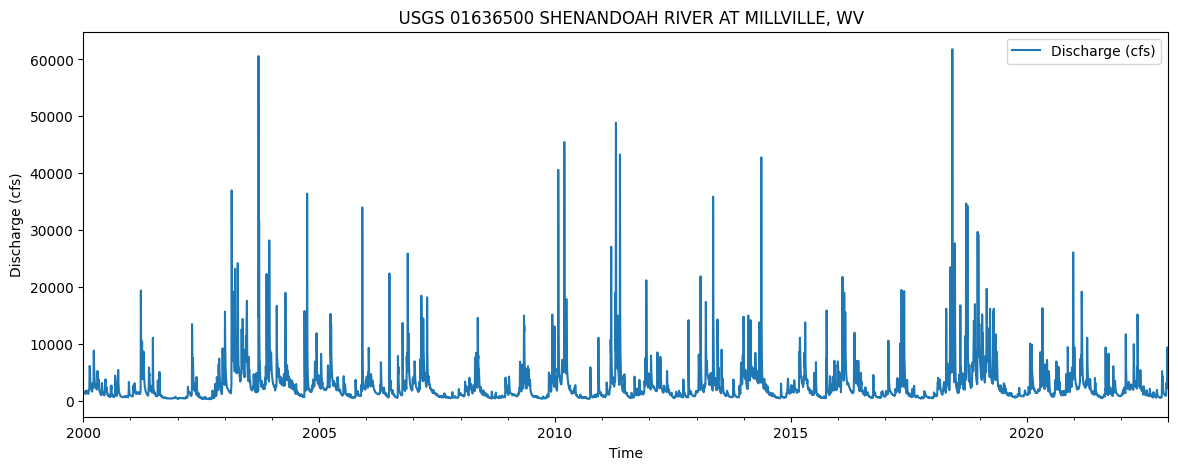

In [51]:
df.plot(figsize=(14,5), title= station_name, xlabel="Time", ylabel="Discharge (cfs)");

### Clean data

In [52]:
df.dropna()
df = df.rename(columns={'Discharge (cfs)': 'streamflow'})

# Calculate baseflow at a single site

In [53]:
from baseflow.separation import single

In [54]:
df

,streamflow
Date,
2000-01-01,1870
2000-01-02,1840
2000-01-03,1780
2000-01-04,1720
2000-01-05,1700
...,...
2022-12-27,4700
2022-12-28,3790
2022-12-29,3230


In [55]:
df['streamflow']

,streamflow
Date,
2000-01-01,1870
2000-01-02,1840
2000-01-03,1780
2000-01-04,1720
2000-01-05,1700
...,...
2022-12-27,4700
2022-12-28,3790
2022-12-29,3230


In [56]:
result = single(df['streamflow'], method='Chapman', return_kge=False)
print(result)

(                Chapman
Date                   
2000-01-01  1870.000000
2000-01-02  1837.500819
2000-01-03  1780.000000
2000-01-04  1720.000000
2000-01-05  1690.173166
...                 ...
2022-12-27  1203.837498
2022-12-28  1235.514717
2022-12-29  1253.427551
2022-12-30  1262.878087
2022-12-31  1266.830467

[8401 rows x 1 columns], None)


In [58]:
result_all = single(df['streamflow'], method='all', return_kge=False)
print(result_all)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at /usr/local/lib/python3.10/dist-packages/baseflow/estimate.py (52)

File "../usr/local/lib/python3.10/dist-packages/baseflow/estimate.py", line 52:
def param_calibrate(param_range, method, Q, b_LH, a):
    <source elided>

@njit(parallel=True)
^ 

This error may have been caused by the following argument(s):
- argument 1: Cannot determine Numba type of <class 'function'> 

This error may have been caused by the following argument(s):
- argument 1: Cannot determine Numba type of <class 'function'> 

This error may have been caused by the following argument(s):
- argument 1: Cannot determine Numba type of <class 'function'> 

This error may have been caused by the following argument(s):
- argument 1: Cannot determine Numba type of <class 'function'> 

This error may have been caused by the following argument(s):
- argument 1: Cannot determine Numba type of <class 'function'> 

This error may have been caused by the following argument(s):
- argument 1: Cannot determine Numba type of <class 'function'> 

This error may have been caused by the following argument(s):
- argument 1: Cannot determine Numba type of <class 'function'> 

This error may have been caused by the following argument(s):
- argument 1: Cannot determine Numba type of <class 'function'>
